# 房价预测

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("data/data.csv")

In [3]:
test = pd.read_csv("data/test.csv")

## 数据概况
- 查看YearBuilt与SalePrice的关系，新建造的房屋价格高？

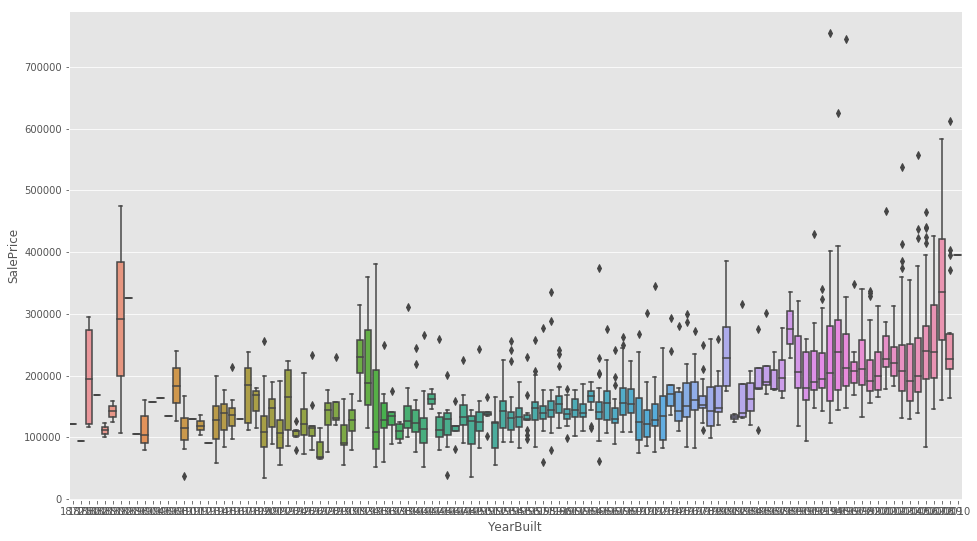

In [4]:
plt.figure(figsize=(16,9))
sns.boxplot(train.YearBuilt, train.SalePrice)

- GrLivArea与SalePrice的关系，右下角的两个点是噪声？

(0, 800000)

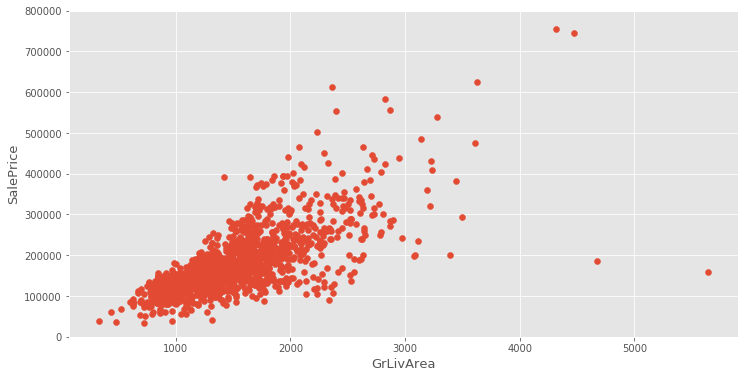

In [5]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

## 去掉噪声
- 去掉这几个样本之后，训练集上分数有所升高，但是在提交到kaggle后表现较好，说明没去掉这几个点，可能过拟合了。

In [6]:
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)
train.drop(train[(train["OverallQual"]<5) & (train["SalePrice"]>200000)].index, inplace=True)

In [7]:
data = pd.concat([train,test], ignore_index=True)

In [8]:
data.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2911,546,546,0,NaN,3,Twnhs,TA,No,0.0,0.0,...,WD,0,Pave,5,546.0,AllPub,0,1970,1970,2006
2912,546,546,0,NaN,3,TwnhsE,TA,No,252.0,0.0,...,WD,0,Pave,6,546.0,AllPub,0,1970,1970,2006
2913,1224,0,0,NaN,4,1Fam,TA,No,1224.0,0.0,...,WD,0,Pave,7,1224.0,AllPub,474,1960,1996,2006
2914,970,0,0,NaN,3,1Fam,TA,Av,337.0,0.0,...,WD,0,Pave,6,912.0,AllPub,80,1992,1992,2006
2915,996,1004,0,NaN,3,1Fam,TA,Av,758.0,0.0,...,WD,0,Pave,9,996.0,AllPub,190,1993,1994,2006


In [9]:
data.drop(['Id'],axis=1, inplace=True)
data.shape

(2916, 80)

## 特征工程与数据填充

In [10]:
# 查看确实值情况
def getnullcount():
    x = data.isnull().sum()
    print(x[x>0].sort_values())
    x[x>0].sort_values().plot.bar()

GarageArea         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
BsmtFinSF2         1
GarageCars         1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
BsmtUnfSF          1
Electrical         1
Functional         2
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtCond          82
BsmtExposure      82
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageQual       159
LotFrontage      485
FireplaceQu     1420
SalePrice       1459
Fence           2345
Alley           2718
MiscFeature     2811
PoolQC          2907
dtype: int64


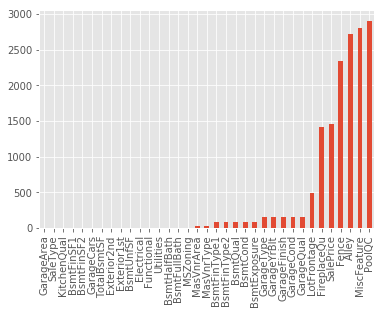

In [11]:
getnullcount()

In [12]:
data["LotAreaCut"] = pd.qcut(data.LotArea,10)
data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
data['LotFrontage']= data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [13]:
cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    data[col].fillna(0, inplace=True)

cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)


SalePrice    1459
dtype: int64


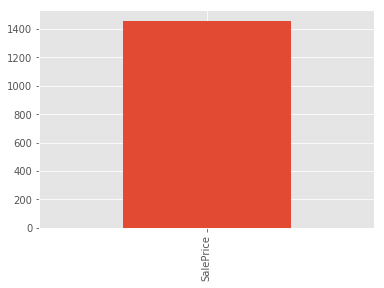

In [14]:
getnullcount()

In [15]:
# data = data.drop(['SqrtLotArea'], axis=1)
data = data.drop(['LotAreaCut'], axis=1)

## 特征工程、特征组合

In [16]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [17]:
cols = data.columns

In [18]:
cols

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [19]:
# 定义一个字典 
feature_map = {}

In [20]:
# MSSubClass（建筑类型）与SalePrice的相关性
data.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
20          185092.521495  159000.0   535
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30

In [21]:
data["MSSubClass"].corr(data['SalePrice'])

-0.08375792177375972

In [22]:
feature_map['uMSSubClass'] = {
    '30':1, '45':1,
    '180':2,
    '190':3, '90':3, '50':3,
    '75':4, '80':4, '20':4, '70':4, 
    '40':5, '85':5, '160':5,'150':5,
    '120':6, '60':6,    
}

In [23]:
def map_values():
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    data["oBldgType"] = data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                              
    return "Done!"

In [24]:
map_values()

'Done!'

In [26]:
lab = LabelEncoder()
data["YearBuilt"] = lab.fit_transform(data["YearBuilt"])
data["YearRemodAdd"] = lab.fit_transform(data["YearRemodAdd"])
data["GarageYrBlt"] = lab.fit_transform(data["GarageYrBlt"].astype(str))

## 数据集准备与模型训练

In [27]:
def dummies_data(train, all_data):
    y = train.SalePrice
    n_train = train.shape[0]
    data_1 = all_data.drop(['SalePrice'], axis=1)
    data_1 = pd.get_dummies(data_1)
    X = data_1[:n_train]
    X_real_test = data_1[n_train:]
    return X, y, X_real_test

In [28]:
X,y,X_real_test = dummies_data(train, data)

In [29]:
def drop_feature_data(train, all_data):
    y = train.SalePrice
    n_train = train.shape[0]
    
    c = train.corr()['SalePrice']
    data_2 = data.drop(['SalePrice'], axis=1)
    data_2.drop(c[(c > 0.0) & (c < 0.1)].index.tolist(),axis=1)
    data_2 = pd.get_dummies(data_2)
    
    X = data_2[:n_train]
    X_real_test = data_2[n_train:]
    return X,y,X_real_test

In [30]:
X.shape

(1457, 323)

In [31]:
X_real_test.shape

(1459, 323)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [33]:
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        max_depth=3,
                        n_estimators=3000,
                        subsample=0.7,
                        reg_alpha=0.0006,
                        nthread=6)

In [34]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=6, objective='reg:linear', random_state=0,
       reg_alpha=0.0006, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [35]:
def benchmark(model, X_test, y_test):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    logrmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(pred)))
    print("RMSE: {} \nLOGRMSE: {}".format(rmse, logrmse))
    return rmse, logrmse

In [36]:
benchmark(xg_reg, X_test, y_test)
# RMSE: 23217.054828354438 
# LOGRMSE: 0.10222134836625894

# (20016.45601852783, 0.10860527675619648)

RMSE: 20328.400168667227 
LOGRMSE: 0.1130426382984117


(20328.400168667227, 0.1130426382984117)

In [54]:
X_1, y_1, X_real_test = drop_feature_data(train, data)

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X_1, y_1, test_size=0.2,random_state=123)

In [56]:
xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3000,subsample=0.7,reg_alpha=0.0006,nthread=6)

In [57]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=6, objective='reg:linear', random_state=0,
       reg_alpha=0.0006, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [58]:
benchmark(xg_reg, X_test, y_test)

RMSE: 20596.64912301572 
LOGRMSE: 0.11274776307907414


(20596.64912301572, 0.11274776307907414)

In [31]:
print(X_1.shape)
print(y_1.shape)

xg_reg = xgb.XGBRegressor(objective='reg:linear',
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        max_depth=3,
                        n_estimators=3000,
                        subsample=0.7,
                        reg_alpha=0.0006,
                        nthread=6)
xg_reg.fit(X_1, y_1)

pred = xg_reg.predict(X_real_test)
result = pd.DataFrame({'Id':test['Id'], 'SalePrice':pred})
result.to_csv("data/submission_4.csv", index=False)

(1457, 404)
(1457,)


In [59]:
sub = pd.read_csv("data/submission_4.csv")
sub

,Id,SalePrice
0,1461,125476.836
1,1462,163270.030
2,1463,187322.300
3,1464,190000.420
4,1465,186048.310
5,1466,174482.550
6,1467,173803.730
7,1468,165265.100
8,1469,183216.440
9,1470,125887.125


-第二次提交，去除噪声点；去掉正相关且相关性小的特征。分数只提高了0.12699->0.12695.哭~

In [37]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=123)
alphas_alt = np.logspace(-10, 2.8, 150)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas_alt, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=alphas_alt, cv=kfolds))
xgboost = make_pipeline(RobustScaler(), xgb.XGBRegressor(
                            objective='reg:linear',
                            colsample_bytree=0.7,
                            learning_rate=0.01,
                            max_depth=3,
                            n_estimators=3000,
                            subsample=0.7,
                            reg_alpha=0.0006,
                            nthread=6,
                            gamma=0,
                            scale_pos_weight=1,
                            seed=123))

In [38]:
stack_alg = StackingCVRegressor(regressors=(ridge,lasso,elasticnet,xgboost),meta_regressor=xgboost)

In [43]:
X = pd.get_dummies(X).reset_index(drop=True)

In [47]:
np.where(np.isnan(X)) 

(array([   0,    1,    2, ..., 1454, 1455, 1456]),
 array([36, 36, 36, ..., 36, 36, 36]))

In [60]:
X = X.fillna(0)

In [65]:
# 查看数据集空集情况，返回两个索引列表。
np.where(np.isnan(X))

(array([], dtype=int64), array([], dtype=int64))

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [67]:
stackX = np.array(X_train)
stacky = np.array(y_train)

In [64]:
stackX[0]

array([8.880e+02, 8.680e+02, 0.000e+00, 3.000e+00, 7.420e+02, 0.000e+00,
       1.000e+00, 0.000e+00, 1.300e+02, 0.000e+00, 0.000e+00, 2.000e+00,
       4.220e+02, 2.000e+00, 8.700e+01, 1.756e+03, 1.000e+00, 1.000e+00,
       9.303e+03, 7.300e+01, 0.000e+00, 6.000e+01, 4.200e+01, 0.000e+00,
       7.000e+00, 1.220e+02, 5.000e+00, 6.000e+00, 0.000e+00, 0.000e+00,
       7.000e+00, 8.720e+02, 1.440e+02, 1.030e+02, 4.700e+01, 2.007e+03,
       0.000e+00, 3.000e+00, 8.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
       5.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 2.000e+00,
       5.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 4.000e+00,
       4.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [56]:
stacky

array([204000, 141000, 136500, ..., 122000, 215000, 123000])

In [68]:
stack_alg.fit(stackX, stacky)

StackingCVRegressor(cv=5,
          meta_regressor=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_de...  reg_alpha=0.0006, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.7))]),
          refit=True,
          regressors=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([1.00000e-10, 1.21873e-10, ..., 5.17719e+02, 6.30957e+02]),
    cv=KFold(n_splits=10, random_state=123...reg_alpha=0.0006, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.7))])),
          shuffle=True, store_train_meta_features=False,
          use_features

In [69]:
def benchmark(model,testset,label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print("Neg Value")
        return -1
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(abs(pred))))
    print("RMSE:",rmse)
    print("LRMSE:",lrmse)
    return lrmse

In [70]:
benchmark(stack_alg, X_test, y_test)

RMSE: 23003.497245881135
LRMSE: 0.11726132888160352


0.11726132888160352